# Exploring and Evaluating Clustering Algorithms (Kmeans, Kmeans++ and Agglomerative Hierarchical Clustering)

## Abstract

Data from Victoria's water fluoridation status by postcode was used to explore the differences between the Kmeans, Kmeans++ and Agglomerative Hierarchical clustering methods. Clustering was performed on the latitude and longitude data points within the data set. The performance of each algorithm was evaluated using purity score using the water companies associated with each suburb as a 'ground truth'.

Source data can be found here:
https://discover.data.vic.gov.au/dataset/victorian-water-fluoridation-status-by-postcode


Import preliminary models for setting up dataframe and perform exploratory data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
pd.set_option("display.notebook_repr_html", False)  # disable "rich" output

# Read csv file as a pandas DataFrame
water_data = pd.read_csv("Fluoridation by postcode - Sheet1.csv", comment="#")

# Print the dimensions of the dataframe
rows = water_data.shape[0]
columns = water_data.shape[1]
print("Number of rows:", water_data.shape[0])
print("Number of columns:", water_data.shape[1])

Number of rows: 1059
Number of columns: 9


In [2]:
# View contents of dataframe
water_data.head(5)

   cartodb_id  melbourne  postcode   id   fluoride_level  \
0         236      False      3227  236      Fluoridated   
1           1       True      3067    1      Fluoridated   
2           2       True      3040    2      Fluoridated   
3           3      False      3352    3  Not fluoridated   
4           4      False      3465    4      Fluoridated   

             water_company     townsuburb        lat         lon  
0             Barwon Water     CONNEWARRE -38.264069  144.462309  
1          City West Water     ABBOTSFORD -37.803000  145.002000  
2          City West Water     ABERFELDIE -37.762000  144.901000  
3  Central Highlands Water      ADDINGTON -37.383333  143.683333  
4  Central Highlands Water  ADELAIDE LEAD -37.083821  143.679125  

After looking at the data we can see that we can work with the latitude and longitude columns for clustering.


In [3]:
# Get data types of all features
water_data.dtypes

# Find medians of features with datatype floater
float_data_medians = water_data.loc[:, ["lat", "lon"]].median()

# Print results
print(water_data.dtypes)
print(f"The median of 'lat' is {float_data_medians['lat']}")
print(f"The median of 'lon' is {float_data_medians['lon']}")


cartodb_id          int64
melbourne            bool
postcode            int64
id                  int64
fluoride_level     object
water_company      object
townsuburb         object
lat               float64
lon               float64
dtype: object
The median of 'lat' is -37.788
The median of 'lon' is 144.989


Explore the different possible values of `fluoride_level` and calculate the ratio of `fluoride_level`.


In [4]:
# Obtain all unique values of 'fluoride_level'
unique_fluoride_levels = water_data.loc[:, "fluoride_level"].unique()

# Print values
print(f"The possible values of the feature 'fluoride_level' are {unique_fluoride_levels}")

# Calculate ratio of each 'fluoride_level'
ratios = (water_data.loc[:, "fluoride_level"].value_counts())/water_data.shape[0]
print(ratios)


The possible values of the feature 'fluoride_level' are ['Fluoridated' 'Not fluoridated' 'Partly fluoridated' 'Natural fluoride']
fluoride_level
Fluoridated           0.743154
Not fluoridated       0.241737
Partly fluoridated    0.013220
Natural fluoride      0.001889
Name: count, dtype: float64


Look for any association between `melbourne` and `fluoride_level`.

In [5]:
# Use .groupby() and .value_counts() 
counts = water_data.groupby('melbourne')['fluoride_level'].value_counts()
print(counts)

# Obtain values to calculate ratios of fluoridation in Melbourne
melbourne_fluoridated = counts[True]['Fluoridated']
total_melbourne = counts[True].sum()
# Calculate ratio
ratio_fluoridated_melbourne = melbourne_fluoridated/total_melbourne
# Print results
print(f"The ratio of fluoridation in Melbourne is {ratio_fluoridated_melbourne}")

# Obtain values to calculate ratios of fluoridation not in Melbourne
not_melbourne_fluoridated = counts[False]['Fluoridated']
total_not_melbourne = counts[False].sum()
# Calculate ratio
ratio_not_fluoridated_melbourne = not_melbourne_fluoridated/total_not_melbourne
# Print results
print(f"The ratio of fluoridation not in Melbourne is {ratio_not_fluoridated_melbourne}")


melbourne  fluoride_level    
False      Fluoridated           406
           Not fluoridated       244
           Partly fluoridated      4
           Natural fluoride        2
True       Fluoridated           381
           Not fluoridated        12
           Partly fluoridated     10
Name: count, dtype: int64
The ratio of fluoridation in Melbourne is 0.9454094292803971
The ratio of fluoridation not in Melbourne is 0.6189024390243902


As the ratio of fluoridation in Melbourne is higher than not in Melbourne, we can see that there tends to be an association between `melbourne` and `fluoride_level`.

Explore the water companies for the different suburbs in Melbourne.

In [6]:
water_companies_per_suburb = water_data.groupby('water_company', as_index=False)['townsuburb'].size().sort_values('size', ascending=False).reset_index(drop=True)
print(water_companies_per_suburb)

                           water_company  size
0                     Yarra Valley Water   205
1                       South East Water   151
2                Central Highlands Water   118
3                           Barwon Water   110
4                        City West Water    83
5                          Coliban Water    56
6                  Goulburn Valley Water    51
7                        Gippsland Water    43
8                       North East Water    41
9                   East Gippsland Water    40
10                              GWMWater    34
11                          Wannon Water    33
12                 South Gippsland Water    25
13                     Westernport Water    25
14                         Western Water    21
15                    Lower Murray Water    20
16  Mount Buller and Mount Stirling ARMB     2
17                     Mount Hotham ARMB     1


Out of the water companies available, Yarra Valley Water and South East Water supply the most suburbs. These are the metropolitan Melbourne areas with the highest population density.

Check which surburb has the most water comapnies.

In [7]:
suburb_water_company = water_data.groupby('townsuburb', as_index=False)['water_company'].size().sort_values('size', ascending=False).reset_index(drop=True)
largest_water_companies = suburb_water_company.drop(suburb_water_company[suburb_water_company['size']==1].index).reset_index(drop=True)
print(largest_water_companies)

     townsuburb  size
0      BELGRAVE     2
1      MULGRAVE     2
2   HUNTINGDALE     2
3     MELBOURNE     2
4        COBURG     2
5      ARMADALE     2
6      OAKLEIGH     2
7    HUGHESDALE     2
8   TULLAMARINE     2
9         UPWEY     2
10      MALVERN     2
11     PAKENHAM     2
12    BAYSWATER     2


These suburbs are the only suburbs that contain the biggest number of water companies.

Check which surburb has the most fluoridated water comapnies.

In [8]:
fluoridated_suburb_water_company = water_data.groupby(['townsuburb', 'fluoride_level'], as_index=False)['water_company'].size().sort_values('size', ascending=False).reset_index(drop=True)
fluoridated_suburb_water_company.drop(fluoridated_suburb_water_company[fluoridated_suburb_water_company['size']==1].index).reset_index(drop=True)
fluoridated_suburb_water_company.head(14)

     townsuburb fluoride_level  size
0      BELGRAVE    Fluoridated     2
1      MULGRAVE    Fluoridated     2
2   HUNTINGDALE    Fluoridated     2
3     MELBOURNE    Fluoridated     2
4        COBURG    Fluoridated     2
5      ARMADALE    Fluoridated     2
6      OAKLEIGH    Fluoridated     2
7    HUGHESDALE    Fluoridated     2
8   TULLAMARINE    Fluoridated     2
9         UPWEY    Fluoridated     2
10      MALVERN    Fluoridated     2
11     PAKENHAM    Fluoridated     2
12    BAYSWATER    Fluoridated     2
13  NORTH SHORE    Fluoridated     1

The same 12 suburbs from question 6 contain the biggest (2) unmber of fluoridated companies.

Create a dataframe that contains the fluoridation status and how many water companies there are for each suburb.

Plot a histogram of the results.

In [9]:
water_companies_by_fluoride_suburb = water_data.groupby(['fluoride_level', 'townsuburb'])['water_company'].nunique().reset_index()
water_companies_by_fluoride_suburb

          fluoride_level     townsuburb  water_company
0            Fluoridated     ABBOTSFORD              1
1            Fluoridated     ABERFELDIE              1
2            Fluoridated  ADELAIDE LEAD              1
3            Fluoridated   AIREYS INLET              1
4            Fluoridated   AIRPORT WEST              1
...                  ...            ...            ...
1041  Partly fluoridated      THE PATCH              1
1042  Partly fluoridated   WANDIN NORTH              1
1043  Partly fluoridated        WOODEND              1
1044  Partly fluoridated  WOORI YALLOCK              1
1045  Partly fluoridated      YELLINGBO              1

[1046 rows x 3 columns]

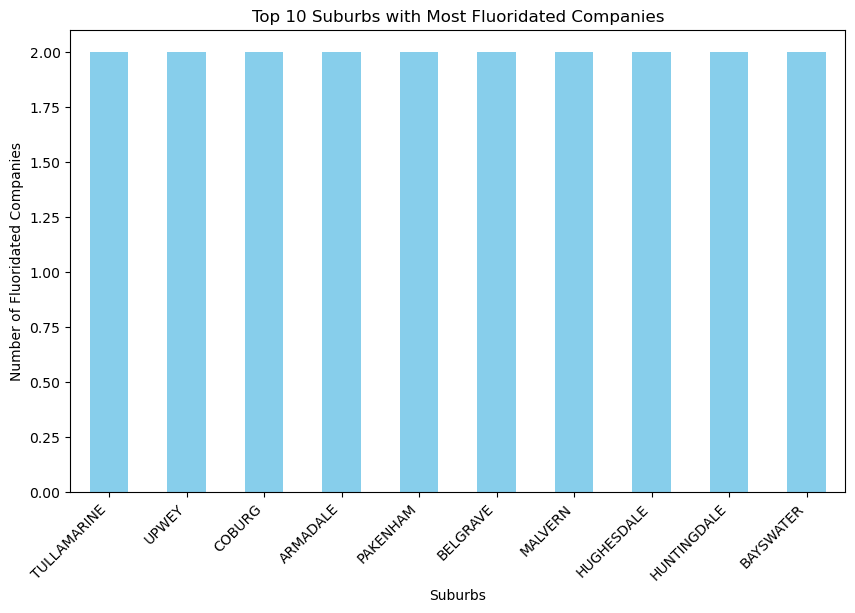

In [10]:
# Filter data for 'Fluoridated' entries only
fluoridated_df = water_data[water_data['fluoride_level'] == 'Fluoridated']

# Group by 'townsuburb' and count unique 'water_company' values
water_companies_by_suburb = fluoridated_df.groupby('townsuburb')['water_company'].nunique()

# Sort values in descending order and select top 10 suburbs
top_10_suburbs = water_companies_by_suburb.sort_values(ascending=False).head(10)

# Plot histogram
plt.figure(figsize=(10, 6))
top_10_suburbs.plot(kind='bar', color='skyblue')
plt.title('Top 10 Suburbs with Most Fluoridated Companies')
plt.xlabel('Suburbs')
plt.ylabel('Number of Fluoridated Companies')
plt.xticks(rotation=45, ha='right')
plt.show()

## Perform clustering on the data
Find optimal number of clusters using Elbow method.

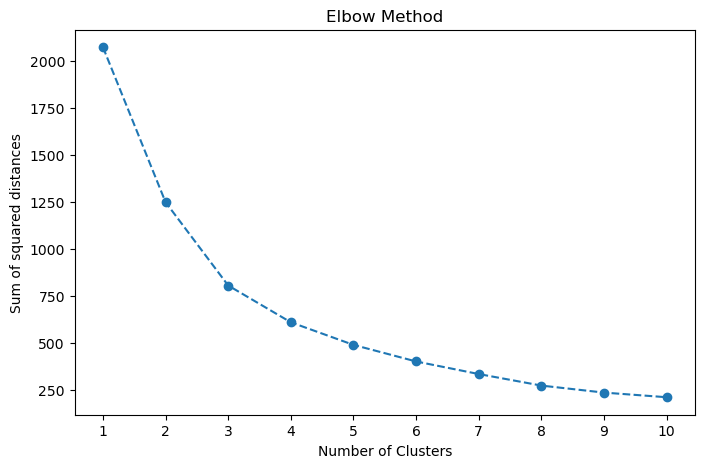

In [11]:
# Extracting features for clustering
X = water_data[['lat', 'lon']]

# Determine the optimal number of clusters using the elbow method
sum_squared_distance = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    kmeans.fit(X)
    sum_squared_distance.append(kmeans.inertia_)

# Plotting the elbow method to determine the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sum_squared_distance, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.xticks(range(1, 11))
plt.show()

# Optimal K using Elbow method is 4 or 5.

Find optimal number of clusters through Silhouette Score

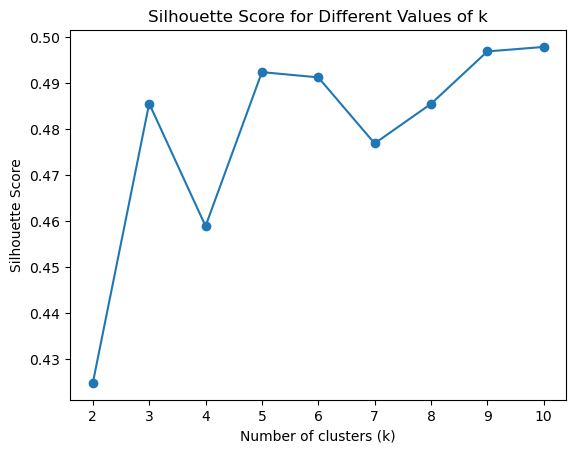

Optimal k value based on Silhouette Score: 10


In [12]:
# Finding optimal K with Silhouette Score
# Initialize a list to store silhouette scores
silhouette_scores = []

# Define range of k values to try
k_values = range(2, 11)

# Iterate over each k value and compute silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg) 

# Find the optimal k value
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))] # 2

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.xticks(k_values)
plt.show()
# Silhouette score is highest for 2 clusters
print(f"Optimal k value based on Silhouette Score: {optimal_k}")

Based on Silhouette score k=10 gives the highest Silhouette Score, however from k=5 or k=6 to k=10 there is only a 0.01 increase in Silhouette score. Suggesting that k=5 is also fairly vaiable.

When comparing the results from Silhouette score to the Elbow method, we can see that Elbow method doesn't give a very distinct optimal k but somewhere around k=5 or k=6 appears to be optimal.

Comparing both results k=5 appears to be a fairly good choice for optimal k value to use for Kmeans++.


### Perform K-Means on the data set using optimal k and find the purity score

In [13]:
# Perform K-Means clustering with k=5
kmeans = KMeans(n_clusters=5, n_init=10, init='random', random_state=42)
kmeans.fit(X)

# Add cluster labels to the DataFrame
water_data['cluster'] = kmeans.labels_

# Print the DataFrame with cluster assignments
print(water_data)

      cartodb_id  melbourne  postcode    id   fluoride_level  \
0            236      False      3227   236      Fluoridated   
1              1       True      3067     1      Fluoridated   
2              2       True      3040     2      Fluoridated   
3              3      False      3352     3  Not fluoridated   
4              4      False      3465     4      Fluoridated   
...          ...        ...       ...   ...              ...   
1054        1055      False      3352  1055      Fluoridated   
1055        1056       True      3770  1056      Fluoridated   
1056        1057      False      3869  1057      Fluoridated   
1057        1058       True      3063  1058      Fluoridated   
1058        1059      False      3418  1059  Not fluoridated   

                water_company     townsuburb        lat         lon  cluster  
0                Barwon Water     CONNEWARRE -38.264069  144.462309        1  
1             City West Water     ABBOTSFORD -37.803000  145.002000      

In [14]:
# Calculating Purity Score
from collections import defaultdict
# Create a dictionary to map each 'water_company' to its majority cluster
company_to_cluster = defaultdict(int)

for company in water_data['water_company'].unique():
    counts = water_data[water_data['water_company'] == company]['cluster'].value_counts()
    majority_cluster = counts.idxmax()  # Find the majority cluster
    company_to_cluster[company] = majority_cluster

# Calculate purity score
total_data_points = len(water_data)
correctly_clustered_data_points = sum(water_data.apply(lambda row: row['cluster'] == company_to_cluster[row['water_company']], axis=1))
km_purity_score = correctly_clustered_data_points / total_data_points

print("Purity Score:", km_purity_score)

Purity Score: 0.882908404154863


### Perform K-Means++ on the data set using optimal k and find the purity score

In [15]:
# Perform K-Means++ clustering with k=5
kmeans = KMeans(n_clusters=5, n_init=10, init='k-means++', random_state=42)
kmeans.fit(X)

# Add cluster labels to the DataFrame
water_data['clusterkplusplus'] = kmeans.labels_

# Print the DataFrame with cluster assignments
print(water_data)

# cluster_counts_kplus = water_data.groupby('water_company')['clusterkplusplus'].value_counts()

      cartodb_id  melbourne  postcode    id   fluoride_level  \
0            236      False      3227   236      Fluoridated   
1              1       True      3067     1      Fluoridated   
2              2       True      3040     2      Fluoridated   
3              3      False      3352     3  Not fluoridated   
4              4      False      3465     4      Fluoridated   
...          ...        ...       ...   ...              ...   
1054        1055      False      3352  1055      Fluoridated   
1055        1056       True      3770  1056      Fluoridated   
1056        1057      False      3869  1057      Fluoridated   
1057        1058       True      3063  1058      Fluoridated   
1058        1059      False      3418  1059  Not fluoridated   

                water_company     townsuburb        lat         lon  cluster  \
0                Barwon Water     CONNEWARRE -38.264069  144.462309        1   
1             City West Water     ABBOTSFORD -37.803000  145.002000    

In [16]:
# Calculating Purity Score
# Create a dictionary to map each 'water_company' to its majority cluster
company_to_cluster = defaultdict(int)

for company in water_data['water_company'].unique():
    counts = water_data[water_data['water_company'] == company]['clusterkplusplus'].value_counts()
    majority_cluster = counts.idxmax()  # Find the majority cluster
    company_to_cluster[company] = majority_cluster

# Calculate purity score
total_data_points = len(water_data)
correctly_clustered_data_points = sum(water_data.apply(lambda row: row['clusterkplusplus'] == company_to_cluster[row['water_company']], axis=1))
kmplus_purity_score = correctly_clustered_data_points / total_data_points

print("Purity Score:", kmplus_purity_score)

Purity Score: 0.9084041548630784


In purity score for Kmeans++ (0.9084041548630784) comparison to Kmeans (0.882908404154863) is slightly higher.

This is fairly expected as we generally expect Kmeans++ to outperform Kmeans given its improved initialisation. 

### Experiment with a different clustering method: Using Agglomerative Clustering

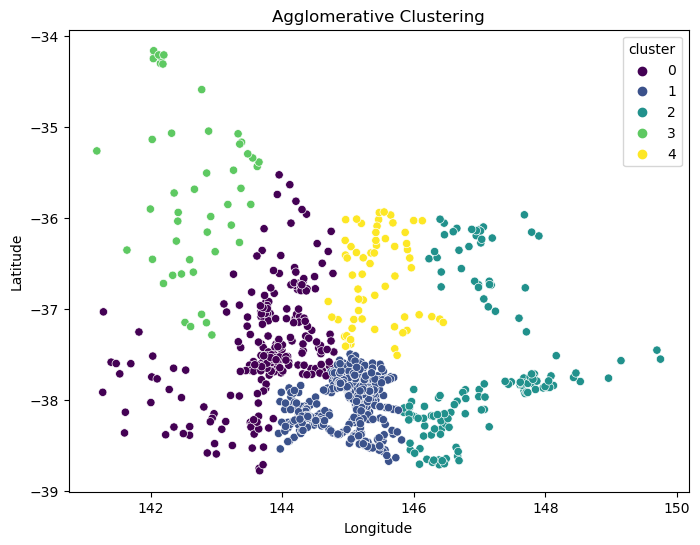

Silhouette Score: 0.43012129821936096


In [17]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.metrics import silhouette_score

df = X.copy()

# Perform Agglomerative Clustering
model = AgglomerativeClustering(n_clusters=5).fit(df)

# Add cluster labels to the DataFrame
df['cluster'] = model.labels_
water_data['agglo_cluster'] = model.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='lon', y='lat', hue='cluster', palette='viridis', legend='full')
plt.title('Agglomerative Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Calculate silhouette score
silhouette_avg = silhouette_score(df[['lat', 'lon']], model.labels_)

print("Silhouette Score:", silhouette_avg)

In [18]:
# Calculating Purity Score
# Create a dictionary to map each 'water_company' to its majority cluster
company_to_cluster = defaultdict(int)

for company in water_data['water_company'].unique():
    counts = water_data[water_data['water_company'] == company]['agglo_cluster'].value_counts()
    majority_cluster = counts.idxmax()  # Find the majority cluster
    company_to_cluster[company] = majority_cluster

# Calculate purity score
total_data_points = len(water_data)
correctly_clustered_data_points = sum(water_data.apply(lambda row: row['agglo_cluster'] == company_to_cluster[row['water_company']], axis=1))
km_purity_score = correctly_clustered_data_points / total_data_points

print("Purity Score:", km_purity_score)

Purity Score: 0.9584513692162417


Calculating a purity score with Agglomerative clustering we get 0.9584513692162417.

In comparison to Kmeans (0.882908404154863) and Kmeans++ (0.9084041548630784) this is a slightly higher purity score.

Agglomerative clustering does not require the number of clusters to be specified beforehand and produces its number of clusters through the linkage criteria.

Interestingly enough, the Agglomerative clustering algorithm has chosen k=5 clusters, which is the same as the k=5 that I have chosen based on my assessment and evaluation. 

This higher purity score suggests that there has been better clustering performance in how well the clusters match to the Ground Truth labels, overall suggesting that Agglomerative clustering has captured the underlying structure of the data more closely. This is further compounded by all three algorithms using k=5 clusters and the purity score for the Agglomerative clustering algorithm producing the highest purity score.
